In [1]:
import json

In [32]:


experiments_path = "../"

def fc_to_string(k,cfg):
    res = f"k_{k}bits_"
    for layer in cfg:
        res += str(layer["bits"]) + "."
    
    res +=  "logsize_"
    for layer in cfg:
        res = res + str(layer["logsize"]) + "."
    
    return res


def bits_str(cfg):
    res = "b."
    for layer in cfg:
        res += str(layer["bits"]) + "."
    
    return res

def logsize_str(cfg):
    res = "sz."
    for layer in cfg:
        res = res + str(layer["logsize"]) + "."
    
    return res
  
def load_configs(name):
    with open(f'{experiments_path}config_{name}', 'r') as myfile:
        data=myfile.read()
        obj = json.loads(data)
        return obj["config"]  

def load_exp(fn):
    try:
        with open(fn, 'r') as myfile:
            data=myfile.read()
            # print(data)
            obj = json.loads(data)
            return obj
    except Exception as err:
        print(err)
        return None

    
polygon_sets = [("Us Zip Codes", "tl_2017_us_zcta510"), ("Global LSB", "Global_LSIB_Polygons_Detailed")]
datasets =[("Twitter 1mio","twitter_1mio_coords.h5"), ("Twitter 10mio","twitter_10mio_coords.h5")]

In [33]:
k = 8;
x = 0;
width = 16 * 8192
height = 16 * 8192;
exp_name = "test_polygons";

cfgs = load_configs(exp_name)

7 12
{'b.1.8.': 0, 'b.1.16.': 1, 'b.1.32.': 2, 'b.1.64.': 3, 'b.8.16.': 4, 'b.8.32.': 5, 'b.8.64.': 6}
{'sz.16.20.': 0, 'sz.16.24.': 1, 'sz.16.28.': 2, 'sz.20.16.': 3, 'sz.20.24.': 4, 'sz.20.28.': 5, 'sz.24.16.': 6, 'sz.24.20.': 7, 'sz.24.28.': 8, 'sz.28.16.': 9, 'sz.28.20.': 10, 'sz.28.24.': 11}


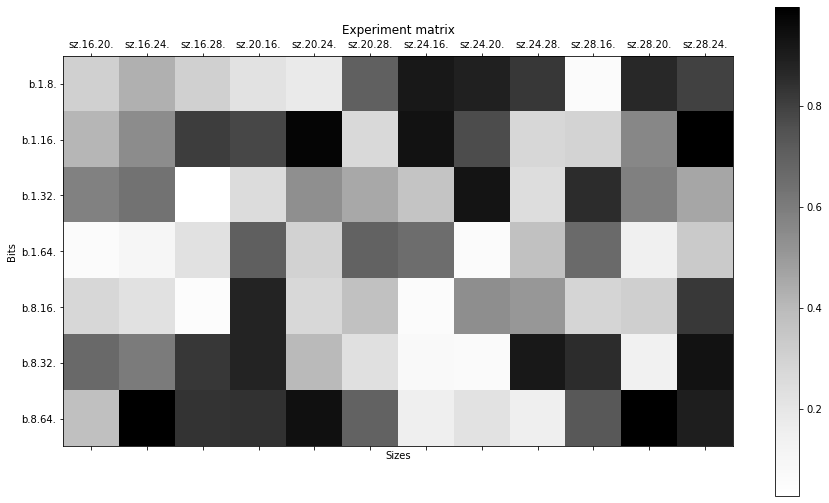

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import matplotlib.backends.backend_pdf as pdf
import tqdm

def save_figs(fn):
    print(f"-->  Saving all figures... {fn}")
    out_pdf = pdf.PdfPages(fn)
    for fig in tqdm.tqdm(range(1, plt.gcf().number+1)):
        out_pdf.savefig( fig )
    out_pdf.close()
    plt.close("all")


def plot_matrix(cm, title='Experiment matrix', cmap='Greys', xlabels=None, ylabels=None, cblabel=None):
    fig = plt.figure(figsize=(len(xlabels)*1.25, 2+ len(ylabels)))
    ax = fig.add_subplot(111)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    cax = ax.matshow(cm,cmap=cmap)
    plt.title(title)
    ax.set_xticks(range(len(xlabels)))
    ax.set_yticks(range(len(ylabels)))
    cbar = fig.colorbar(cax)

    if cblabel:
        cbar.set_label(cblabel)
    if xlabels:
        ax.set_xticklabels(list(xlabels))
    if ylabels:
        ax.set_yticklabels(list(ylabels))
    plt.xlabel('Sizes')
    plt.ylabel('Bits')
    #plt.show()


def make_maps(size, cfgs):
    bits_map = {}
    logsize_map = {}

    count_bits =0
    count_sizes = 0
    for c in cfgs :

        if len(c) ==size:
            if(not bits_str(c) in bits_map):
                bits_map[bits_str(c)] = count_bits
                count_bits+=1
            if(not logsize_str(c) in logsize_map):
                logsize_map[logsize_str(c)] = count_sizes
                count_sizes+=1
    return bits_map, logsize_map

bits_map, logsize_map = make_maps(2,cfgs)

print(len(bits_map), len(logsize_map))
print(bits_map)
print(logsize_map)
a = np.random.rand(len(bits_map), len(logsize_map))
plot_matrix(a, ylabels=bits_map.keys(), xlabels=logsize_map.keys())


In [42]:
def make_matrices(size, cfgs):
    bits_map, logsize_map = make_maps(size,cfgs)
    matrices= {}
    matrix_indices = ["err_mean_pc"]
    for shapen,shapef in polygon_sets:
        matrices[shapef] = {}
        for dn, ds in datasets :
            matrices[shapef][ds] = {}
            for mi in matrix_indices:
                matrices[shapef][ds][mi] = np.zeros((len(bits_map),(len(logsize_map))))-1



    x=0
    for c in cfgs :
        # print(fc_to_string(k,c))
        y = 0;
        for shpn, shapef in polygon_sets:
            for  dn, ds in datasets :
                fn = experiments_path + exp_name + "/" + exp_name + f'.w{width}h{height}.{x:04d}.{y}-' + fc_to_string(k,c) \
                + ds + "." + shapef + ".json"
                # print(fn)
                data = load_exp(fn)
                bits = bits_str(c)
                sz = logsize_str(c)
                if data and bits in bits_map and  sz in logsize_map:
                    for mi in matrix_indices:
                        matrices[shapef][ds][mi][ bits_map[bits],logsize_map[sz]] = data[mi]
            y+=1
        x+=1

    for shpn, shapef in polygon_sets:
        for  dn, ds in datasets :
            for mi in matrix_indices:   
                plot_matrix( matrices[shapef][ds][mi] ,title=f'{dn} - {shpn}',ylabels=bits_map.keys(), xlabels=logsize_map.keys(), cblabel="% Error")             

make_matrices(1, cfgs)   
make_matrices(2, cfgs)              
make_matrices(3, cfgs)              


save_figs("polygons_test_matrices.pdf")

-->  Saving all figures... polygons_test_matrices.pdf


100%|██████████| 12/12 [00:00<00:00, 16.98it/s]
